# Import

In [2]:
import json
import re
import ast
from tqdm import tqdm
import torch
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm

# Data

In [3]:
# Charger les données traitées pour inspection
with open('pilener_train.json', 'r') as f:
    processed_data = json.load(f)

# Afficher un exemple
example_idx = 0  # Modifier cet indice pour voir d'autres exemples
example = processed_data[example_idx]

# Afficher avec une mise en forme claire
print("=== Exemple traité ===")
print("Tokenized Text:")
print(example['tokenized_text'])
print("\nNER Spans:")
for span in example['ner']:
    print(f" - Start: {span[0]}, End: {span[1]}, Entity Type: {span[2]}")
print("\nNegative Entities:")
print(example['negative'])

=== Exemple traité ===
Tokenized Text:
['Q', ':', 'Position', 'character', 'based', 'on', 'enemy', 'coordinates', 'in', 'lua', 'I', 'have', 'written', 'a', 'function', 'here', 'which', 'should', 'turn', 'my', 'character', 'based', 'on', 'enemy', 'coordinates', 'but', 'it', "'", 's', 'not', 'perfect', 'because', 'it', 'does', 'not', 'always', 'turn', 'where', 'I', 'want', 'it', 'to', 'and', 'perhaps', 'there', 'is', 'a', 'better', 'way', 'of', 'writing', 'it', 'local', 'myPosition', '=', '{', 'x', '=', '350', ',', 'y', '=', '355', '}', 'local', 'enemyPosition', '=', '{', 'x', '=', '352', ',', 'y', '=', '354', '}', 'local', 'xValue', ',', 'yValue', ',', 'xDir', ',', 'yDir', ',', 'dir', 'if', 'myPosition', '.', 'x', '>', 'enemyPosition', '.', 'x', 'then', 'xValue', '=', 'myPosition', '.', 'x', '-', 'enemyPosition', '.', 'x', 'elseif', 'myPosition', '.', 'x', '<', 'enemyPosition', '.', 'x', 'then', 'xValue', '=', 'myPosition', '.', 'x', '-', 'enemyPosition', '.', 'x', 'else', 'xValue', '='

faut allez à lendroit ou est defini le model puis vous pouvez exec la suite dans lordre

In [4]:
model = GLiNER(pretrained_model_name="microsoft/deberta-v3-base", span_max_length=2, hidden_size=768)
# Initialiser le modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

c:\Users\doria\anaconda3\envs\vincentorch\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
c:\Users\doria\anaconda3\envs\vincentorch\Lib\site-packages\transformers\convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


GLiNER(
  (encoder): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
              (dropou

In [5]:
from transformers import AutoTokenizer
import torch
from tqdm import tqdm
import json

def prepare_data_for_training(processed_data, model, max_length=64, max_entity_per_seq = 25):
    input_ids, labels, entity_tensors, attention_masks = [], [], [], []
    entity_masks, sentence_masks = [], []

    # Créer un mapping des types d'entités vers des entiers
    entity_types = {entity for entry in processed_data for _, _, entity in entry["ner"]}
    special_tokens = [f"[ENT] {entity}" for entity in entity_types]
    model.tokenizer.add_special_tokens({"additional_special_tokens": special_tokens})
    model.encoder.resize_token_embeddings(len(model.tokenizer))

    for entry in tqdm(processed_data, desc="Processing Data", unit="entry"):
        tokenized_text = entry["tokenized_text"]
        ner_spans = entry["ner"]
                
        # Générer le tensor de labels
        label_tensor = torch.zeros(max_length, dtype=torch.long)
        current_entity_id = []
        current_entity_str = []

        for start, end, entity_type in ner_spans:
            if start < max_length and end < max_length and len(current_entity_str)<max_entity_per_seq:
                entity_token_id = model.tokenizer.convert_tokens_to_ids(f'[ENT] {entity_type}')
                label_tensor[start:end + 1] = entity_token_id

                if entity_token_id not in current_entity_id:
                    current_entity_id.append(entity_token_id)
                if entity_type not in current_entity_str:
                    current_entity_str.append(entity_type)

        entity_tokens = " ".join(f"[ENT] {et}" for et in current_entity_str)
        
        # Tokeniser la séquence principale
        encoded = model.tokenizer(
            tokenized_text, return_tensors="pt", padding="max_length", truncation=True, 
            is_split_into_words=True, add_special_tokens=False
        )

        word_ids = encoded.word_ids()
        first_subtoken_ids = [
            encoded["input_ids"][0, i].item() for i, word_id in enumerate(word_ids) 
            if word_id is not None and (i == 0 or word_ids[i - 1] != word_id)
        ]

        encoded_entity = model.tokenizer(
            entity_tokens, return_tensors="pt", padding="max_length", truncation=True, 
            is_split_into_words=False, add_special_tokens=False
        )

        if len(current_entity_str) != len(encoded_entity["input_ids"][0]) or len(tokenized_text) != len(first_subtoken_ids):
            print("error, not same size")
            continue

        encoded_entity = encoded_entity["input_ids"][0].tolist() + [0]*(max_entity_per_seq-len(current_entity_str))

        sep_id = model.tokenizer.convert_tokens_to_ids(f'[SEP]')

        combined_ids = (
            encoded_entity +
            [sep_id] +
            first_subtoken_ids
        )

        if len(combined_ids) != max_entity_per_seq + len(first_subtoken_ids) + 1:
            print("error, not same size")
            continue

        deleted_ids = max(len(combined_ids) - max_length,0)
        combined_ids = combined_ids[:max_length]
        combined_ids += [0] * (max_length - len(combined_ids))

        # Créer l'attention mask
        attention_mask = [1 if id != 0 else 0 for id in combined_ids]

        # Masques spécifiques pour les entités et la phrase
        entity_mask = [1 if i < len(current_entity_str) else 0 for i in range(len(combined_ids))]
        sentence_mask = [1 if i > len(encoded_entity) and combined_ids[i] != 0 and combined_ids[i] != sep_id else 0 
                         for i in range(len(combined_ids))]

        # Vérification des tailles
        if sum(entity_mask) != len(current_entity_str):
            print(f"Entity mask size mismatch: {sum(entity_mask)} != {len(current_entity_str)}")
            continue
        if sum(sentence_mask) != len(tokenized_text)-deleted_ids:
            print(f"Sentence mask size mismatch: {sum(sentence_mask)} != {len(tokenized_text)-deleted_ids}")
            continue

        current_entity_id = current_entity_id + [0]*(max_entity_per_seq-len(current_entity_str))

        # Convertir les entités en un tensor
        entity_tensor = torch.tensor(current_entity_id, dtype=torch.long)
        
        # Ajouter les données
        input_ids.append(torch.tensor(combined_ids, dtype=torch.long))
        labels.append(label_tensor)
        entity_tensors.append(entity_tensor)
        attention_masks.append(torch.tensor(attention_mask, dtype=torch.long))
        entity_masks.append(torch.tensor(entity_mask, dtype=torch.long))
        sentence_masks.append(torch.tensor(sentence_mask, dtype=torch.long))

    return (
        torch.stack(input_ids), 
        torch.stack(labels), 
        entity_tensors, 
        torch.stack(attention_masks), 
        torch.stack(entity_masks), 
        torch.stack(sentence_masks)
    )



# Charger les données générées précédemment
with open('pilener_train.json', 'r') as f:
    processed_data = json.load(f)

# Préparer les données avec suivi d'avancement
input_ids, labels, entity_tensors, attention_masks, entity_masks, sentence_masks = prepare_data_for_training(processed_data, model)


Processing Data:   0%|          | 0/45889 [00:00<?, ?entry/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Processing Data:  10%|▉         | 4390/45889 [00:14<02:05, 330.93entry/s]

error, not same size


Processing Data:  34%|███▍      | 15547/45889 [00:47<01:29, 337.92entry/s]

error, not same size


Processing Data:  38%|███▊      | 17430/45889 [00:53<01:25, 331.91entry/s]

error, not same size


Processing Data:  53%|█████▎    | 24230/45889 [01:14<01:05, 332.19entry/s]

error, not same size


Processing Data:  64%|██████▍   | 29380/45889 [01:29<00:50, 329.54entry/s]

error, not same size


Processing Data:  73%|███████▎  | 33380/45889 [01:41<00:37, 330.41entry/s]

error, not same size


Processing Data:  76%|███████▌  | 34898/45889 [01:46<00:32, 334.69entry/s]

error, not same size


Processing Data:  88%|████████▊ | 40346/45889 [02:02<00:16, 337.92entry/s]

error, not same size


Processing Data: 100%|██████████| 45889/45889 [02:19<00:00, 329.20entry/s]


In [6]:
print(len(model.tokenizer))
print(len(input_ids))
print(len(entity_tensors))

143177
45881
45881


In [7]:
# Afficher les formes des tensors principaux
print(f"Forme de input_ids : {input_ids.shape}")
print(f"Forme de attention_masks : {attention_masks.shape}")
print(f"Forme de labels : {labels.shape}")
print(f"Forme de entity_masks : {entity_masks.shape}")
print(f"Forme de sentence_masks : {sentence_masks.shape}")

# Afficher un exemple pour les tensors principaux
print("\nExemple de input_ids (première entrée) :")
print(input_ids[0])

print("\nExemple de attention_masks (première entrée) :")
print(attention_masks[0])

print("\nExemple de labels (première entrée) :")
print(labels[0])

# Afficher un exemple pour les entity_tensors
print("\nExemple de entity_tensors (première entrée) :")
print(entity_tensors[0])

# Afficher un exemple pour les entity_masks
print("\nExemple de entity_masks (première entrée) :")
print(entity_masks[0])

# Afficher un exemple pour les sentence_masks
print("\nExemple de sentence_masks (première entrée) :")
print(sentence_masks[0])

Forme de input_ids : torch.Size([45881, 64])
Forme de attention_masks : torch.Size([45881, 64])
Forme de labels : torch.Size([45881, 64])
Forme de entity_masks : torch.Size([45881, 64])
Forme de sentence_masks : torch.Size([45881, 64])

Exemple de input_ids (première entrée) :
tensor([130368, 128249, 138174,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      2,   1729,
           877,  18172,   1470,    636,    277,   4648,  14321,    267,  96792,
           273,    286,   1223,    266,   1571,    422,    319,    403,    930,
           312,   1470,    636,    277,   4648,  14321,    304,    278,    382,
          1550,    298,    801,    401,    278,    490,    298,    489,    930,
           399])

Exemple de attention_masks (première entrée) :
tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 

# Dataset and Dataloader

In [8]:
proportion = 0.1

In [9]:
from torch.utils.data import DataLoader, Dataset, random_split
import torch

class NERDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels, entities,entity_masks,sentence_masks , max_span_length=2):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.entity_masks = entity_masks
        self.sentence_masks =sentence_masks
        self.labels = labels  # Liste des labels pour chaque token
        self.entities = entities  # Liste des entités uniques
        self.max_span_length = max_span_length

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        input_id = self.input_ids[idx]
        attention_mask = self.attention_masks[idx]
        token_labels = self.labels[idx]  # Labels token-par-token
        entity_ids = self.entities[idx]  # Entités pour cet exemple

        num_tokens = len(input_id) - len(entity_ids) - 1
        spans = [
            (start, end)
            for start in range(num_tokens)
            for end in range(start, min(start + self.max_span_length, num_tokens))
        ]
        num_spans = len(spans)
        num_entities = len(entity_ids)

        # Matrice binaire : spans x entities
        binary_labels = torch.zeros(num_spans, num_entities, dtype=torch.float)

        for span_idx, (start, end) in enumerate(spans):
            span_labels = token_labels[start:end + 1]
            for entity_idx, entity_id in enumerate(entity_ids):
                if all((label == entity_id and label != 0)  for label in span_labels):
                    binary_labels[span_idx, entity_idx] = 1

        return input_id, attention_mask, spans, entity_ids, binary_labels, sentence_masks, entity_masks


In [10]:
ind = int(len(input_ids) * proportion)

In [11]:
# Créer le dataset
dataset = NERDataset(input_ids[:ind], attention_masks[:ind], labels[:ind], entity_tensors[:ind],entity_masks[:ind],sentence_masks[:ind])

# Exemple de récupération d'une entrée
input_id, attention_mask, spans, entity_ids, binary_labels, sentence_masks, entity_masks = dataset[0]

print("Input ID:", input_id)
print("Spans:", spans)
print("Entity IDs:", entity_ids)
print("Binary Labels:", binary_labels)

Input ID: tensor([130368, 128249, 138174,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      2,   1729,
           877,  18172,   1470,    636,    277,   4648,  14321,    267,  96792,
           273,    286,   1223,    266,   1571,    422,    319,    403,    930,
           312,   1470,    636,    277,   4648,  14321,    304,    278,    382,
          1550,    298,    801,    401,    278,    490,    298,    489,    930,
           399])
Spans: [(0, 0), (0, 1), (1, 1), (1, 2), (2, 2), (2, 3), (3, 3), (3, 4), (4, 4), (4, 5), (5, 5), (5, 6), (6, 6), (6, 7), (7, 7), (7, 8), (8, 8), (8, 9), (9, 9), (9, 10), (10, 10), (10, 11), (11, 11), (11, 12), (12, 12), (12, 13), (13, 13), (13, 14), (14, 14), (14, 15), (15, 15), (15, 16), (16, 16), (16, 17), (17, 17), (17, 18), (18, 18), (18, 19), (19, 19), (19, 20), (20, 20), (20, 21), (21, 21), (21, 22), (22,

In [12]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    input_ids, attention_masks, spans, entity_ids, binary_labels, sentence_masks, entity_masks = zip(*batch)

    # Trouver les tailles maximales pour le padding
    max_len = max(len(ids) for ids in input_ids)  # Longueur max des tokens
    max_spans = max(len(s) for s in spans)  # Nombre max de spans
    max_entities = max(len(e) for e in entity_ids)  # Nombre max d'entités

    # Padding des input_ids et attention_masks
    # padded_input_ids = torch.stack([
    #     torch.cat([ids, torch.zeros(max_len - len(ids), dtype=torch.long)])
    #     for ids in input_ids
    # ])
    # padded_attention_masks = torch.stack([
    #     torch.cat([mask, torch.zeros(max_len - len(mask), dtype=torch.long)])
    #     for mask in attention_masks
    # ])

    # Padding des spans
    # spans = torch.stack([
    #     torch.cat([torch.tensor(s, dtype=torch.long), torch.zeros((max_spans - len(s), 2), dtype=torch.long)])
    #     for s in spans
    # ])

    # Padding des entity_ids
    # padded_entity_ids = torch.stack([
    #     torch.cat([e, torch.zeros(max_entities - len(e), dtype=torch.long)])
    #     for e in entity_ids
    # ])

    # Padding des binary_labels
    # binary_labels = torch.stack([
    #     torch.cat([
    #         torch.cat([bl, torch.zeros(max_spans - bl.size(0), bl.size(1))], dim=0) if bl.size(0) < max_spans else bl,
    #         torch.zeros(max_spans, max_entities - bl.size(1)) if bl.size(1) < max_entities else torch.zeros(0)
    #     ], dim=1)
    #     for bl in binary_labels
    # ])

        # Conversion en tensors
        #spans = [torch.tensor(s, dtype=torch.long) for s in spans]
    input_ids = torch.stack([ids.clone().detach() for ids in input_ids])
    attention_masks = torch.stack([mask.clone().detach() for mask in attention_masks]) 
    entity_ids = torch.stack([e.clone().detach() for e in entity_ids])
    binary_labels = torch.stack([bl.clone().detach() for bl in binary_labels])
    sentence_masks = torch.stack([sm.clone().detach() for sm in sentence_masks])
    entity_masks = torch.stack([em.clone().detach() for em in entity_masks])
    spans = torch.tensor([span for span in spans], dtype=torch.long)

    return input_ids, attention_masks, spans, entity_ids, binary_labels, sentence_masks, entity_masks


In [13]:
# Définir les proportions pour le train, validation et test
train_ratio = 0.8  # 80% des données pour l'entraînement
val_ratio = 0.1    # 10% des données pour la validation
test_ratio = 0.1   # 10% des données pour le test

# Calculer les tailles des différents ensembles
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

# Diviser les données en train, validation, et test
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Créer les DataLoaders pour chaque ensemble
batch_size = 16  # Ajuster selon vos besoins
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


# Vérification des tailles
print(f"Train size: {len(train_loader)}")
print(f"Validation size: {len(val_loader)}")
print(f"Test size: {len(test_loader)}")


Train size: 230
Validation size: 29
Test size: 29


# Model

## architecture model

In [14]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel

class GLiNER(nn.Module):
    def __init__(self, pretrained_model_name="microsoft/deberta-v3-base", span_max_length=2, hidden_size=768):
        super(GLiNER, self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
        self.encoder = AutoModel.from_pretrained(pretrained_model_name)

        self.entity_ffn = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )
        
        self.span_ffn = nn.Sequential(
            nn.Linear(2 * hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )
        
        self.sigmoid = nn.Sigmoid()
        
        self.span_max_length = span_max_length
        self.loss_fn = nn.BCELoss()  # Binary Cross-Entropy Loss

    def forward(self, input_ids, attention_masks, entity_types, spans, sentence_masks, entity_masks, binary_labels=None):
        # print("Input IDs shape:", input_ids.shape)
        # print("Attention mask shape:", attention_masks.shape)
        # Passer input_ids et attention_masks au modèle
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_masks)
        token_embeddings = outputs.last_hidden_state
    
        entity_embeddings, text_embeddings = self.split_embeddings(token_embeddings,len(entity_types[0]))
        

        refined_entity_embeddings = self.entity_ffn(entity_embeddings)
        
        span_scores = self.compute_span_scores(refined_entity_embeddings, text_embeddings, spans)

        if binary_labels is not None:
            loss = self.compute_loss(span_scores, binary_labels)
            return span_scores, loss
        
        return span_scores


    def split_embeddings(self, token_embeddings, num_entity_types = 25):
        entity_embeddings = token_embeddings[:, 0:num_entity_types, :]
        text_embeddings = token_embeddings[:, num_entity_types + 1:, :]
        
        return entity_embeddings, text_embeddings

    
    def compute_span_scores(self, entity_embeddings, text_embeddings, spans):
        """
        Calcule les scores des spans en une seule passe vectorisée, 
        en supposant que tous les spans sont valides.
        """
        batch_size, text_length, hidden_size = text_embeddings.shape

        # Conversion des spans en tensor directement
        spans_tensor = torch.stack([torch.tensor(s, device=text_embeddings.device) for s in spans])  # (batch, num_spans, 2)

        # Récupération des embeddings des spans
        i_indices = spans_tensor[:, :, 0].unsqueeze(-1).expand(-1, -1, hidden_size)  # (batch, num_spans, hidden_size)
        j_indices = spans_tensor[:, :, 1].unsqueeze(-1).expand(-1, -1, hidden_size)

        start_embeddings = torch.gather(text_embeddings, 1, i_indices)  # (batch, num_spans, hidden_size)
        end_embeddings = torch.gather(text_embeddings, 1, j_indices)    # (batch, num_spans, hidden_size)

        # Concaténer les embeddings des extrémités et passer dans la FFN
        span_reprs = torch.cat([start_embeddings, end_embeddings], dim=-1)  # (batch, num_spans, 2 * hidden_size)
        span_reprs = self.span_ffn(span_reprs)                              # (batch, num_spans, hidden_size)

        # Calcul des scores pour toutes les entités
        scores = torch.einsum("bsh,beh->bse", span_reprs, entity_embeddings)  # (batch, num_spans, num_entity_types)

        # Appliquer la sigmoïde pour les scores finaux
        span_scores = self.sigmoid(scores)

        return span_scores


    def compute_loss(self, span_scores, binary_labels):
        """
        Calcul de la perte binaire cross-entropy entre les scores et les étiquettes.
        """
        # print(f"span_scores shape: {span_scores.shape}")
        # print(f"binary_labels shape: {binary_labels.shape}")

        # Appliquer la perte
        loss = self.loss_fn(span_scores, binary_labels)
        return loss


## train

In [15]:
import torch
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm

# Hyperparamètres
num_epochs = 5
learning_rate = 1e-5

# Optimiseur et scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * num_epochs
)

# Fonction d'entraînement avec tqdm
def train_epoch(model, train_loader, optimizer, scheduler):
    model.train()
    total_loss = 0

    # Ajout de tqdm pour afficher la progression
    progress_bar = tqdm(train_loader, desc="Training", unit="batch")
    for batch in progress_bar:
        input_ids, attention_masks, spans, entity_ids, binary_labels, sentence_masks, entity_masks = [b.to(device) for b in batch]

        optimizer.zero_grad()

        span_scores, loss = model(
            input_ids=input_ids,
            attention_masks=attention_masks,
            entity_types=entity_ids,
            spans=spans,
            binary_labels=binary_labels,
            sentence_masks=sentence_masks,
            entity_masks=entity_masks
        )

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        # Mise à jour de la barre de progression
        progress_bar.set_postfix({"Batch Loss": loss.item()})

    avg_loss = total_loss / len(train_loader)
    return avg_loss

# Boucle d'entraînement avec tqdm
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, scheduler)
    print(f"Train Loss: {train_loss:.4f}")



Epoch 1/5


Training:   0%|          | 0/230 [00:00<?, ?batch/s]C:\Users\doria\AppData\Local\Temp\ipykernel_32132\3357513992.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spans_tensor = torch.stack([torch.tensor(s, device=text_embeddings.device) for s in spans])  # (batch, num_spans, 2)
Training: 100%|██████████| 230/230 [03:26<00:00,  1.11batch/s, Batch Loss=0.0243]


Train Loss: 0.0364
Epoch 2/5


Training: 100%|██████████| 230/230 [03:25<00:00,  1.12batch/s, Batch Loss=0.0197]


Train Loss: 0.0201
Epoch 3/5


Training: 100%|██████████| 230/230 [03:25<00:00,  1.12batch/s, Batch Loss=0.0199]


Train Loss: 0.0188
Epoch 4/5


Training: 100%|██████████| 230/230 [03:26<00:00,  1.11batch/s, Batch Loss=0.0193]


Train Loss: 0.0183
Epoch 5/5


Training: 100%|██████████| 230/230 [03:25<00:00,  1.12batch/s, Batch Loss=0.0202] 

Train Loss: 0.0181


## test

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Fonction pour calculer la précision, le rappel, le F1-score et la matrice de confusion
def calculate_metrics(binary_scores, binary_labels):
    # Déplacer les tensors vers le CPU avant de les convertir en NumPy
    binary_scores_flat = binary_scores.cpu().flatten()
    binary_labels_flat = binary_labels.cpu().flatten()

    # Calcul des métriques
    precision = precision_score(binary_labels_flat, binary_scores_flat)
    recall = recall_score(binary_labels_flat, binary_scores_flat)
    f1 = f1_score(binary_labels_flat, binary_scores_flat)

    # Matrice de confusion
    cm = confusion_matrix(binary_labels_flat, binary_scores_flat)

    return precision, recall, f1, cm

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(confusion_matrix, normalize=False):
    plt.figure(figsize=(6, 4))

    # Normalisation de la matrice de confusion si nécessaire
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    print(confusion_matrix)
    # Affichage de la matrice de confusion avec format ajusté
    sns.heatmap(confusion_matrix, annot=True, fmt='.4f' if normalize else 'g', cmap='Blues', cbar=False, 
                xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['True Negative', 'True Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [18]:
def test_epoch(model, test_loader):
    model.eval()  # Passer en mode évaluation
    total_loss = 0
    test_loss = 0
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    confusion_matrix_total = torch.zeros(2, 2)  # Confusion matrix for binary classification

    progress_bar = tqdm(test_loader, desc="Testing", unit="batch")
    with torch.no_grad():  # Désactiver les gradients pour la phase de test
        for batch in progress_bar:
            input_ids, attention_masks, spans, entity_ids, binary_labels, sentence_masks, entity_masks = [b.to(device) for b in batch]

            span_scores, loss = model(
                input_ids=input_ids,
                attention_masks=attention_masks,
                entity_types=entity_ids,
                spans=spans,
                binary_labels=binary_labels,
                sentence_masks=sentence_masks,
                entity_masks=entity_masks
            )

            total_loss += loss.item()

            # Calcul des autres métriques
            binary_scores = (span_scores >= 0.5).float()  # Convertir les scores en prédictions binaires
            precision, recall, f1, cm = calculate_metrics(binary_scores, binary_labels)
            
            total_precision += precision
            total_recall += recall
            total_f1 += f1
            confusion_matrix_total += torch.tensor(cm)

            # Mise à jour de la barre de progression
            progress_bar.set_postfix({"Batch Loss": loss.item()})

    avg_loss = total_loss / len(test_loader)
    # Moyenne des métriques
    average_precision = total_precision / len(test_loader)
    average_recall = total_recall / len(test_loader)
    average_f1 = total_f1 / len(test_loader)
    confusion_matrix_total = confusion_matrix_total.numpy()

    return avg_loss, average_precision,average_recall,average_f1,confusion_matrix_total

In [19]:
test_loss, test_precision, test_recall, test_f1, cm = test_epoch(model, test_loader)

Testing:   0%|          | 0/29 [00:00<?, ?batch/s]C:\Users\doria\AppData\Local\Temp\ipykernel_32132\3357513992.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spans_tensor = torch.stack([torch.tensor(s, device=text_embeddings.device) for s in spans])  # (batch, num_spans, 2)
Testing:   3%|▎         | 1/29 [00:00<00:24,  1.13batch/s, Batch Loss=0.0181]C:\Users\doria\AppData\Local\Temp\ipykernel_32132\3357513992.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spans_tensor = torch.stack([torch.tensor(s, device=text_embeddings.device) for s in spans])  # (batch, num_spans, 2)
Testing:   7%|▋         | 2/29 [00:01<00:22,  1.21batch/s, Batch Loss=0.0161]C:\Users\doria\AppData\Local\T

Test Loss: 0.0170
Test Precision: 0.4807
Test Recall: 0.0763
Test F1 Score: 0.1264
[[9.99473907e-01 5.26092926e-04]
 [9.23620393e-01 7.63796066e-02]]


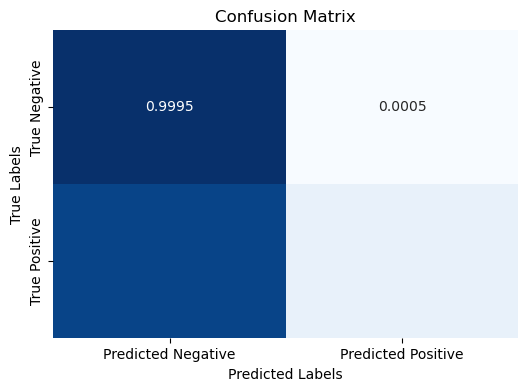

In [20]:
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
plot_confusion_matrix(cm,True)

- cm[0, 0] = TN
- cm[0, 1] = FP
- cm[1, 0] = FN
- cm[1, 1] = TP


# Save & Load

In [ ]:
# Sauvegarder le modèle complet
torch.save(model, "model_fullBest.pth")
# Sauvegarder le modèle
torch.save(model.state_dict(), "modelBest.pth")

PicklingError: Can't pickle <class '__main__.GLiNER'>: it's not the same object as __main__.GLiNER